# Analysis of aggregate results (HAN only)

This is the version that produces the graphs and tables that are published in the thesis document.

In [1]:
# Imports
import os
import sys
sys.path.append(os.path.dirname(os.path.abspath('')))
# print(sys.path)
import pandas as pd
import datetime
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# import seaborn as sns
import matplotlib.ticker as ticker

from scipy.stats import pearsonr
import pingouin as pg

from lib.analysis_tools import plot_boxes_grade_cats

In [2]:
abt_spad = pd.read_csv('../data/han_spad_abt.csv')
abt_oopd = pd.read_csv('../data/han_oopd_abt.csv')
# abt_oop = pd.read_csv('../data/hu_oop_abt.csv')

abt = pd.concat([abt_spad.copy(), abt_oopd.copy()]).reset_index(drop = True).copy()
abt
# abt.to_excel('~/Downloads/abt_matthijs.xlsx', index = False)

,assignment,file,kloc,submission_date,grade,subgrade_datatypes,subgrade_methods,subgrade_control_structures,subgrade_events,subgrade_coding_standard,...,checkstyle_AnonInnerLength,checkstyle_AvoidNoArgumentSuperConstructorCall,checkstyle_ClassDataAbstractionCoupling,checkstyle_ClassFanOutComplexity,checkstyle_CovariantEquals,checkstyle_EmptyCatchBlock,checkstyle_HideUtilityClassConstructor,checkstyle_InterfaceIsType,checkstyle_LambdaBodyLength,checkstyle_NestedTryDepth
0,HAN SPAD,aGFzaDg1NzE4NjQ2OTU5MDg3NDcyNTk=,0.905,2019-10-31,8.5,10.0,8.0,10.0,10.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HAN SPAD,aGFzaC0yNzM0NTA5Nzk1MjQwNjY0Mjk5,0.994,2019-11-01,7.0,8.0,8.0,8.0,8.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HAN SPAD,aGFzaDE2Mzc4OTM3Nzk1MTg4NDY4MjY=,0.492,2019-11-01,7.4,8.0,8.0,8.0,8.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HAN SPAD,aGFzaC0zNzAwMjU4OTk1NTE5MzQ2ODQy,0.448,2019-10-30,8.2,8.0,8.0,10.0,6.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HAN SPAD,aGFzaDgzMTY2MjQwNjA2Nzk3MzA4ODU=,0.468,2019-11-01,7.9,8.0,8.0,8.0,8.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1221,HAN OOPD,aGFzaC0xMzgwOTE0OTQ2MDQyNDMyMDYx,2.677,2022-04-07,8.5,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.373552,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
1222,HAN OOPD,aGFzaDg2Mjc1NDEwMzU0MTk3NDQ1MzQ=,2.123,2022-03-30,7.1,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.413095,0.942063,0.0,0.0,0.471032,0.0,0.0,0.0
1223,HAN OOPD,aGFzaC0yNjYwNTU5NDUyMjIyMDk4MjM0,1.893,2022-05-13,6.4,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.528262,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
1224,HAN OOPD,aGFzaDg2MzQ0MzUxMTE1Mzc4NDg2MTA=,1.042,2022-05-12,8.4,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0


# Cleanup

In [3]:
print(f"Number of assignments total: {abt['grade'].count()} ")
print(f"Number of assignments with a grade of zero: {abt[abt['grade'] < 1]['grade'].count()}")
print(f"Number of assignments where no errors could be detected: {abt[abt['errors_total'] == 0]['grade'].count()}")
# abt[abt['errors_total'] == 0]

abt_clean = abt[(abt['grade'] >= 1) & (abt['errors_total'] > 0)].reset_index(drop = True).copy()

print(f"Number of assignments after cleanup: {abt_clean['grade'].count()}")

# Drop columns for subgrades
abt_clean = abt_clean.drop([x for x in abt_clean.columns if x.startswith('subgrade')],axis = 1)

# NaNs are metrics that were not found for a specific assignment. Just set them to 0
abt_clean = abt_clean.fillna(0)

# Failing grades are distributed unevenly because they contain knockout values.
# Set all of them to 4.0 if they're lower than 4.0
abt_clean.grade = abt_clean['grade'].map(lambda x : 5.0 if x < 5.0 else x)


# HU OOP has either pass or fail. Fail has been mapped to 4.0 above.
# Here map pass to 7.5 (average between 5.5 and 10)
abt_clean.loc[abt_clean['assignment'] == 'HU OOP', 'grade'] = abt_clean[abt_clean['assignment'] == 
        'HU OOP']['grade'].apply(lambda x : 7.5 if x > 5.5 else x)
# abt_clean[abt_clean['assignment'] == 'HU OOP']['grade']
# abt_oop['grade'] = abt_oop['grade'].apply(lambda x : 7.0 if x >=5.5 else 5.0)


Number of assignments total: 1226 
Number of assignments with a grade of zero: 46
Number of assignments where no errors could be detected: 41
Number of assignments after cleanup: 1141


In [4]:



# Only retain columns for categories, clusters and totals.
abt_final = abt_clean[['grade', 
                       'errors_count',
                       'errors_total'] + [x for x in abt_clean.columns if x.startswith('cluster_') ] +
                       ['pmd_count',
                       'pmd_total'] + [x for x in abt_clean.columns if x.startswith('pmd_cat_')] +
                       ['checkstyle_count',
                        'checkstyle_total'] + [x for x in abt_clean.columns if x.startswith('checkstyle_cat_')]].reset_index(drop = True).copy()
# Additionally, create columns for the categories teachers were
# questioned about.
abt_final['cat_Code style'] = abt_final['pmd_cat_Code style'].copy()
abt_final['cat_Design'] = abt_final['pmd_cat_Design'] + abt_final['checkstyle_cat_Class Design']
abt_final['cat_ErrorProne'] = abt_final['pmd_cat_ErrorProne'].copy()
abt_final['cat_SizeViolations'] = abt_final['checkstyle_cat_SizeViolations'].copy()


In [5]:
# Normalize values between 0 and 1
must_normalize = False

if must_normalize:
    for x in abt_final.columns:
        if x == 'grade':
          continue
        abt_final[x] = abt_final[x] / abt_final[x].max()

abt_final
    # .apply(lambda x : x / x.max(), axis = 0)

,grade,errors_count,errors_total,cluster_Best practices,cluster_Complexity,cluster_Incomplete code,cluster_Reusability and extendibility,cluster_Side effects,pmd_count,pmd_total,...,checkstyle_cat_Block Checks,checkstyle_cat_Class Design,checkstyle_cat_Coding,checkstyle_cat_Imports,checkstyle_cat_Metrics,checkstyle_cat_SizeViolations,cat_Code style,cat_Design,cat_ErrorProne,cat_SizeViolations
0,8.5,34.254144,537.016575,121.546961,6.629834,67.403315,341.436464,0.000000,19.889503,155.801105,...,0.000000,169.060773,198.895028,4.419890,5.524862,3.314917,104.972376,204.419890,1.104972,3.314917
1,7.0,47.283702,588.531187,182.092555,9.054326,22.132797,375.251509,0.000000,32.193159,181.086519,...,0.000000,132.796781,264.587525,7.042254,3.018109,0.000000,136.820926,152.917505,9.054326,0.000000
2,7.4,56.910569,575.203252,178.861789,10.162602,71.138211,315.040650,0.000000,34.552846,217.479675,...,6.097561,176.829268,162.601626,8.130081,4.065041,0.000000,168.699187,213.414634,0.000000,0.000000
3,8.2,98.214286,870.535714,381.696429,22.321429,55.803571,372.767857,37.946429,55.803571,386.160714,...,0.000000,116.071429,343.750000,8.928571,11.160714,4.464286,314.732143,145.089286,4.464286,4.464286
4,7.9,49.145299,722.222222,243.589744,10.683761,115.384615,350.427350,2.136752,29.914530,286.324786,...,0.000000,151.709402,271.367521,8.547009,4.273504,0.000000,262.820513,173.076923,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1136,8.5,16.062757,688.830781,116.174823,2.614867,31.004856,537.915577,1.120657,10.459470,146.432574,...,0.000000,38.849458,500.560329,0.747105,1.120657,1.120657,107.583115,64.251027,2.988420,1.120657
1137,7.1,21.667452,439.001413,86.669807,8.007537,68.770608,275.082431,0.471032,12.717852,131.417805,...,0.000000,56.994819,236.457843,7.065473,4.239284,2.826189,74.422986,106.453132,0.471032,2.826189
1138,6.4,23.243529,659.270998,156.893819,8.452192,62.863180,431.061807,0.000000,13.734812,192.287375,...,0.000000,55.995774,397.253038,8.452192,4.226096,1.056524,151.611199,87.163233,1.056524,1.056524
1139,8.4,16.314779,194.817658,75.815739,0.000000,54.702495,64.299424,0.000000,10.556622,113.243762,...,0.000000,17.274472,64.299424,0.000000,0.000000,0.000000,75.815739,50.863724,2.879079,0.000000


# Distribution of grades

Text(0.5, 1.0, 'Distribution of grades after cleanup')

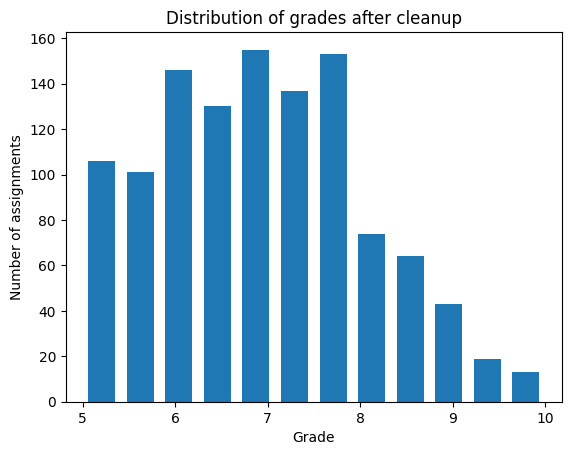

In [6]:
ax = abt_final['grade'].hist(bins=12, rwidth = 0.7)
ax.grid(False)
ax.set_xlabel('Grade')
ax.set_ylabel('Number of assignments')
ax.set_title('Distribution of grades after cleanup')

## Distribution of failing grades before cleanup

Text(0.5, 1.0, 'Distribution of failing grades before cleanup')

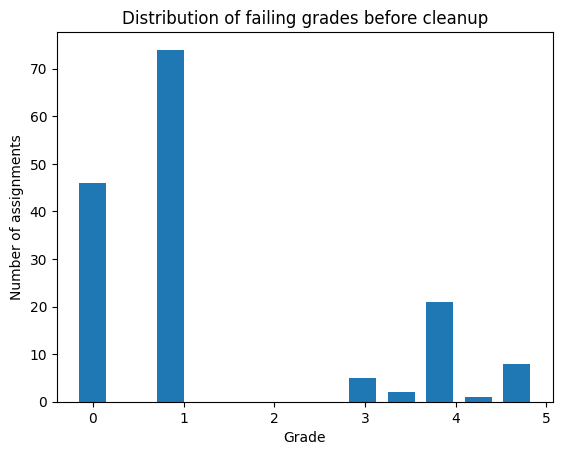

In [7]:
ax = abt[abt['grade'] < 5.5]['grade'].hist(
    bins = 12, 
    rwidth = 0.7, 
    align="left")
ax.grid(False)
ax.set_xlabel('Grade')
ax.set_ylabel('Number of assignments')
ax.set_title('Distribution of failing grades before cleanup')

# Correlations

## Correlations for all grades

In [8]:
corr = abt_final.corr(method='spearman') # Spearman to correct for non-normal distribution. Effect is very small, however.
corr.style.background_gradient(cmap='coolwarm')

,grade,errors_count,errors_total,cluster_Best practices,cluster_Complexity,cluster_Incomplete code,cluster_Reusability and extendibility,cluster_Side effects,pmd_count,pmd_total,pmd_cat_Best practices,pmd_cat_Code style,pmd_cat_Design,pmd_cat_ErrorProne,checkstyle_count,checkstyle_total,checkstyle_cat_Block Checks,checkstyle_cat_Class Design,checkstyle_cat_Coding,checkstyle_cat_Imports,checkstyle_cat_Metrics,checkstyle_cat_SizeViolations,cat_Code style,cat_Design,cat_ErrorProne,cat_SizeViolations
grade,1.000000,-0.371765,-0.243304,-0.012893,-0.137193,-0.285052,-0.258834,0.132712,-0.363764,-0.058276,0.021663,-0.047003,-0.060696,0.139585,-0.359980,-0.274888,-0.017748,-0.219560,-0.240909,-0.288890,-0.129708,0.020574,-0.047003,-0.220265,0.139585,0.020574
errors_count,-0.371765,1.000000,0.698348,0.564137,0.378766,0.469262,0.616924,0.159200,0.984184,0.556748,0.085838,0.520925,0.184898,-0.163315,0.974286,0.651655,0.010427,0.720052,0.479596,0.797343,0.322537,0.071195,0.520925,0.714146,-0.163315,0.071195
errors_total,-0.243304,0.698348,1.000000,0.672365,0.485277,0.423342,0.925683,0.187899,0.652263,0.631274,0.023031,0.598466,0.249750,-0.157367,0.725245,0.950038,-0.020044,0.729270,0.816313,0.680292,0.415033,0.294362,0.598466,0.738996,-0.157367,0.294362
cluster_Best practices,-0.012893,0.564137,0.672365,1.000000,0.255688,0.363667,0.451820,0.250298,0.548006,0.902259,0.116976,0.912844,0.198563,-0.011512,0.559388,0.494704,-0.031475,0.648541,0.329097,0.520490,0.186536,0.142796,0.912844,0.639866,-0.011512,0.142796
cluster_Complexity,-0.137193,0.378766,0.485277,0.255688,1.000000,0.032510,0.495620,0.075451,0.314249,0.182579,0.034984,0.083579,0.292010,0.012090,0.439302,0.527349,0.034841,0.261044,0.529854,0.269232,0.907884,0.534524,0.083579,0.335053,0.012090,0.534524
cluster_Incomplete code,-0.285052,0.469262,0.423342,0.363667,0.032510,1.000000,0.235325,0.082224,0.472219,0.586953,0.071183,0.458600,0.549231,-0.123387,0.439884,0.298866,0.007868,0.454029,0.176559,0.355832,0.038359,-0.038950,0.458600,0.553757,-0.123387,-0.038950
cluster_Reusability and extendibility,-0.258834,0.616924,0.925683,0.451820,0.495620,0.235325,1.000000,0.119239,0.568291,0.385556,-0.015224,0.379153,0.139278,-0.191355,0.651561,0.984084,-0.019148,0.664725,0.901348,0.632217,0.422677,0.289016,0.379153,0.654178,-0.191355,0.289016
cluster_Side effects,0.132712,0.159200,0.187899,0.250298,0.075451,0.082224,0.119239,1.000000,0.158287,0.247986,0.351207,0.227396,0.024140,-0.031506,0.151464,0.138021,-0.009982,0.207362,0.084660,0.164959,0.053048,0.092876,0.227396,0.199365,-0.031506,0.092876
pmd_count,-0.363764,0.984184,0.652263,0.548006,0.314249,0.472219,0.568291,0.158287,1.000000,0.562739,0.138828,0.516453,0.185939,-0.121942,0.921048,0.595480,0.006589,0.696217,0.423842,0.757065,0.247640,0.005553,0.516453,0.693052,-0.121942,0.005553
pmd_total,-0.058276,0.556748,0.631274,0.902259,0.182579,0.586953,0.385556,0.247986,0.562739,1.000000,0.176190,0.914634,0.439829,-0.019512,0.524101,0.411240,-0.018265,0.626293,0.232691,0.470532,0.118529,0.081308,0.914634,0.686771,-0.019512,0.081308


In [9]:
pearson_vals = []
pd.reset_option('display.float_format')
# pd.options.display.float_format = '{:,.4f}'.format
for cat in abt_final.columns.to_numpy():
    if cat == 'grade':
        continue
    result = pearsonr(abt_final['grade'], abt_final[cat])
    confidence_interval = result.confidence_interval(confidence_level = 0.95)
    pearson_vals.append({
        'Metric' : cat,
        'Average value': round(abt_final[cat].mean()),
        'SD' : float(round(abt_final[cat].std() * 100)) / 100,
        'Correlation coefficient' : float(round(result.statistic * 100)) / 100,
        'P-value' : result.pvalue,
        'P-value disp' : float(int(result.pvalue * 100000)) / 100000,
        'Confidence interval .95 low' : confidence_interval[0],
        'Confidence interval .95 high' : confidence_interval[1],
    })
pd.DataFrame(pearson_vals).to_excel('../data/all_han_pearson_vals.xlsx')
pd.DataFrame(pearson_vals)

,Metric,Average value,SD,Correlation coefficient,P-value,P-value disp,Confidence interval .95 low,Confidence interval .95 high
0,errors_count,51,27.68,-0.31,7.564914e-27,0.00000,-0.361589,-0.256645
1,errors_total,578,250.37,-0.24,4.251972e-16,0.00000,-0.291542,-0.182000
2,cluster_Best practices,181,71.02,0.01,7.749109e-01,0.77491,-0.049584,0.066477
3,cluster_Complexity,12,11.66,-0.16,3.555140e-08,0.00000,-0.218244,-0.105220
4,cluster_Incomplete code,77,40.35,-0.24,6.454933e-17,0.00000,-0.297735,-0.188548
5,cluster_Reusability and extendibility,303,200.10,-0.24,1.078707e-16,0.00000,-0.296066,-0.186783
6,cluster_Side effects,4,8.04,0.02,5.951853e-01,0.59518,-0.042327,0.073714
7,pmd_count,30,15.62,-0.31,1.132223e-26,0.00000,-0.360603,-0.255584
8,pmd_total,227,77.43,-0.04,2.007696e-01,0.20076,-0.095727,0.020176
9,pmd_cat_Best practices,13,10.02,0.00,9.506327e-01,0.95063,-0.056206,0.059863


## Correlations for passing grades only

In [10]:
corr = abt_final[abt_final['grade'] >= 5.5].corr()
corr.style.background_gradient(cmap='coolwarm')

,grade,errors_count,errors_total,cluster_Best practices,cluster_Complexity,cluster_Incomplete code,cluster_Reusability and extendibility,cluster_Side effects,pmd_count,pmd_total,pmd_cat_Best practices,pmd_cat_Code style,pmd_cat_Design,pmd_cat_ErrorProne,checkstyle_count,checkstyle_total,checkstyle_cat_Block Checks,checkstyle_cat_Class Design,checkstyle_cat_Coding,checkstyle_cat_Imports,checkstyle_cat_Metrics,checkstyle_cat_SizeViolations,cat_Code style,cat_Design,cat_ErrorProne,cat_SizeViolations
grade,1.000000,-0.319063,-0.253705,-0.039335,-0.181052,-0.243472,-0.247402,0.001837,-0.321921,-0.083219,-0.000414,-0.047158,-0.110930,-0.048582,-0.301682,-0.266262,-0.007203,-0.232080,-0.211165,-0.191015,-0.155132,-0.033174,-0.047158,-0.238456,-0.048582,-0.033174
errors_count,-0.319063,1.000000,0.570218,0.498925,0.283998,0.587527,0.394043,0.279631,0.984473,0.558338,0.154675,0.525753,0.138111,0.183988,0.975939,0.463173,0.047463,0.580861,0.282262,0.769020,0.239508,0.166528,0.525753,0.554506,0.183988,0.166528
errors_total,-0.253705,0.570218,1.000000,0.622600,0.470017,0.389767,0.927491,0.210741,0.534315,0.586166,0.092132,0.543307,0.236689,0.129405,0.590097,0.955448,-0.012229,0.631667,0.847343,0.417979,0.415377,0.323988,0.543307,0.629238,0.129405,0.323988
cluster_Best practices,-0.039335,0.498925,0.622600,1.000000,0.207232,0.371077,0.326936,0.283222,0.491186,0.914184,0.150008,0.912667,0.158898,0.226098,0.486910,0.394769,-0.011016,0.606515,0.213253,0.369153,0.143851,0.238029,0.912667,0.583450,0.226098,0.238029
cluster_Complexity,-0.181052,0.283998,0.470017,0.207232,1.000000,0.081695,0.441178,0.117738,0.220953,0.133349,0.004376,0.022681,0.287666,0.158350,0.350000,0.500867,-0.004903,0.255337,0.451134,0.107299,0.821761,0.559532,0.022681,0.312578,0.158350,0.559532
cluster_Incomplete code,-0.243472,0.587527,0.389767,0.371077,0.081695,1.000000,0.144511,0.131858,0.583955,0.608955,0.090032,0.499453,0.516571,0.000719,0.566495,0.233787,0.017150,0.399044,0.097046,0.539113,0.111578,0.071865,0.499453,0.508819,0.000719,0.071865
cluster_Reusability and extendibility,-0.247402,0.394043,0.927491,0.326936,0.441178,0.144511,1.000000,0.090186,0.356157,0.266690,0.025757,0.242884,0.119925,0.072090,0.424022,0.987073,-0.014199,0.473537,0.950585,0.272568,0.398607,0.271649,0.242884,0.454275,0.072090,0.271649
cluster_Side effects,0.001837,0.279631,0.210741,0.283222,0.117738,0.131858,0.090186,1.000000,0.268259,0.300729,0.443570,0.274107,-0.003735,0.012049,0.281634,0.136797,-0.013852,0.274679,0.044436,0.172704,0.132793,0.136938,0.274107,0.241278,0.012049,0.136938
pmd_count,-0.321921,0.984473,0.534315,0.491186,0.220953,0.583955,0.356157,0.268259,1.000000,0.567381,0.185138,0.528020,0.135888,0.206529,0.922511,0.417908,0.039681,0.567979,0.237975,0.754471,0.169477,0.098658,0.528020,0.542463,0.206529,0.098658
pmd_total,-0.083219,0.558338,0.586166,0.914184,0.133349,0.608955,0.266690,0.300729,0.567381,1.000000,0.209026,0.932974,0.395707,0.163733,0.522902,0.320914,0.000884,0.597451,0.129922,0.441585,0.082915,0.162712,0.932974,0.647265,0.163733,0.162712


In [11]:
pearson_vals = []
for cat in abt_final.columns.to_numpy():
    if cat == 'grade':
        continue
    result = pearsonr(abt_final['grade'], abt_final[cat])
    confidence_interval = result.confidence_interval(confidence_level = 0.95)
    pearson_vals.append({
        'Metric' : cat,
        'Average value': round(abt_final[cat].mean()),
        'SD' : float(round(abt_final[cat].std() * 100)) / 100,
        'Correlation coefficient' : float(round(result.statistic * 100)) / 100,
        'P-value' : result.pvalue,
        'P-value disp' : float(int(result.pvalue * 100000)) / 100000,
        'Confidence interval .95 low' : confidence_interval[0],
        'Confidence interval .95 high' : confidence_interval[1],
    })
pd.DataFrame(pearson_vals)

,Metric,Average value,SD,Correlation coefficient,P-value,P-value disp,Confidence interval .95 low,Confidence interval .95 high
0,errors_count,51,27.68,-0.31,7.564914e-27,0.00000,-0.361589,-0.256645
1,errors_total,578,250.37,-0.24,4.251972e-16,0.00000,-0.291542,-0.182000
2,cluster_Best practices,181,71.02,0.01,7.749109e-01,0.77491,-0.049584,0.066477
3,cluster_Complexity,12,11.66,-0.16,3.555140e-08,0.00000,-0.218244,-0.105220
4,cluster_Incomplete code,77,40.35,-0.24,6.454933e-17,0.00000,-0.297735,-0.188548
5,cluster_Reusability and extendibility,303,200.10,-0.24,1.078707e-16,0.00000,-0.296066,-0.186783
6,cluster_Side effects,4,8.04,0.02,5.951853e-01,0.59518,-0.042327,0.073714
7,pmd_count,30,15.62,-0.31,1.132223e-26,0.00000,-0.360603,-0.255584
8,pmd_total,227,77.43,-0.04,2.007696e-01,0.20076,-0.095727,0.020176
9,pmd_cat_Best practices,13,10.02,0.00,9.506327e-01,0.95063,-0.056206,0.059863


# Distribution of errors

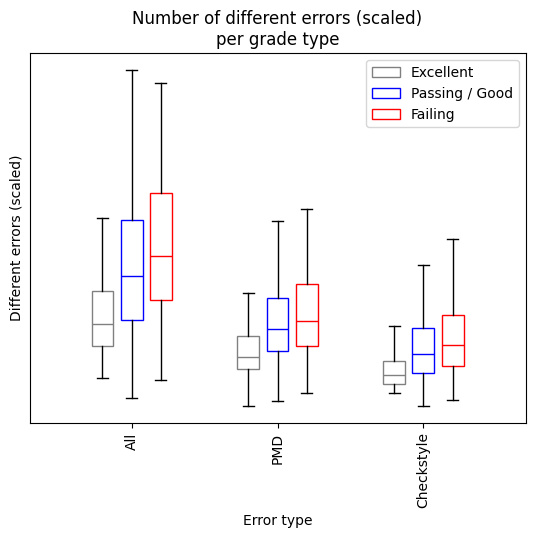

In [12]:
plot_boxes_grade_cats(abt_final, ['errors_count', 'pmd_count', 'checkstyle_count'],
           ['All', 'PMD', 'Checkstyle'],
           "Number of different errors (scaled)\nper grade type",
           'Error type',
           'Different errors (scaled)',
           hide_y = True
           )

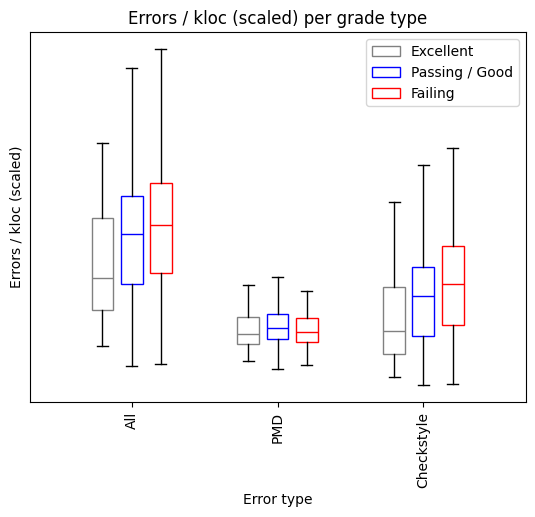

In [13]:
plot_boxes_grade_cats(abt_final, ['errors_total', 'pmd_total', 'checkstyle_total'],
           ['All', 'PMD', 'Checkstyle'],
           "Errors / kloc (scaled) per grade type",
           'Error type',
           'Errors / kloc (scaled)',
           hide_y = True
           )

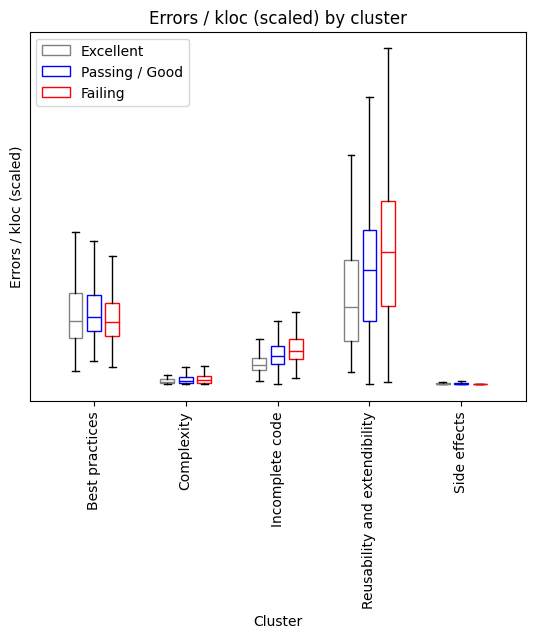

In [14]:
cluster_columns = [x for x in abt_final.columns if x.startswith("cluster_")]
labels = [x.replace('cluster_', '') for x in cluster_columns]


plot_boxes_grade_cats(abt_final,
           cluster_columns,
           labels,
           'Errors / kloc (scaled) by cluster',
           'Cluster',
           'Errors / kloc (scaled)',
           hide_y = True
           )

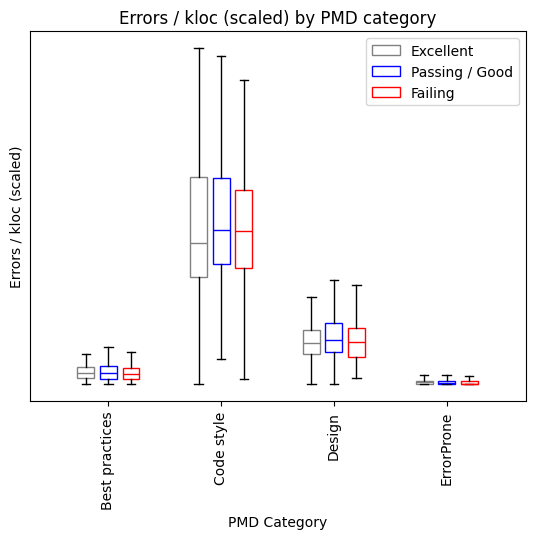

In [15]:
# Individual PMD categories
categories = [x for x in abt_final.columns if x.startswith('pmd_cat_')]
labels = [x.replace('pmd_cat_', '') for x in categories]

plot_boxes_grade_cats(abt_final,
    categories,
           labels,
           'Errors / kloc (scaled) by PMD category',
           'PMD Category',
           'Errors / kloc (scaled)',
           hide_y = True)

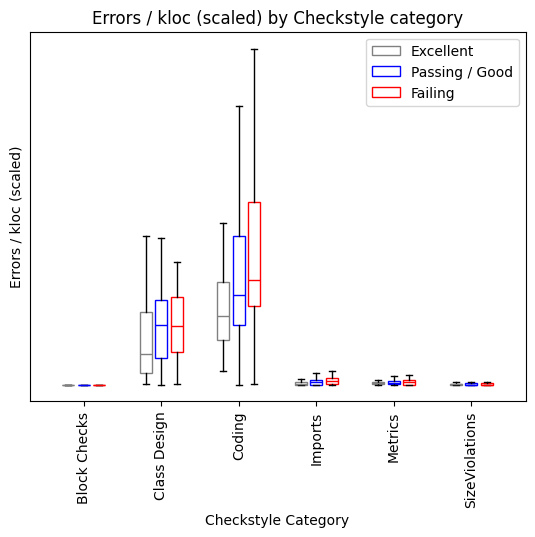

In [16]:
# Individual Checkstyle categories
categories = [x for x in abt_final.columns if x.startswith('checkstyle_cat_')]
labels = [x.replace('checkstyle_cat_', '') for x in categories]

plot_boxes_grade_cats(abt_final,
    categories,
           labels,
           'Errors / kloc (scaled) by Checkstyle category',
           'Checkstyle Category',
           'Errors / kloc (scaled)',
           hide_y = True)

/var/folders/zc/pfyjhy252g1fmlpp0765mxtm0000gn/T/ipykernel_7340/109590687.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abt_cats.loc[:, ('Design')] = abt_cats['checkstyle_cat_Class Design'] + abt_cats['pmd_cat_Design']


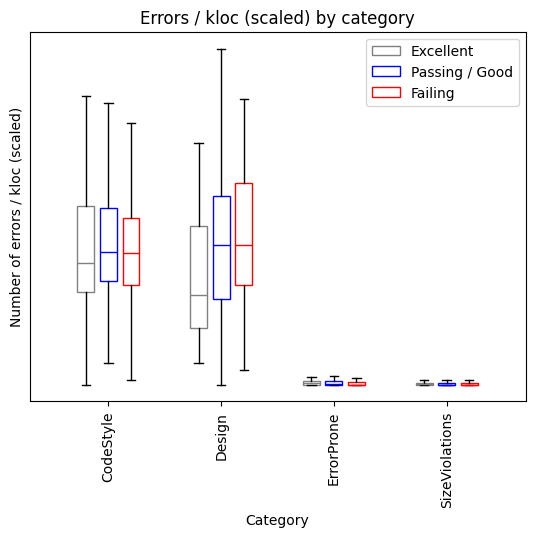

In [17]:
# Categories teachers were questioned on
# Individual PMD categories
abt_cats = abt_final[['grade', 
                      'checkstyle_cat_Class Design',
                      'checkstyle_cat_SizeViolations',
                      'pmd_cat_Design',
                      'pmd_cat_Code style',
                      'pmd_cat_ErrorProne',
                      ]]
abt_cats.loc[:, ('Design')] = abt_cats['checkstyle_cat_Class Design'] + abt_cats['pmd_cat_Design']
abt_cats = abt_cats.rename({
    'checkstyle_cat_SizeViolations': 'SizeViolations',
    'pmd_cat_Code style' : 'CodeStyle',
    'pmd_cat_ErrorProne' : 'ErrorProne'
}, axis = 1).drop(['checkstyle_cat_Class Design', 'pmd_cat_Design'], axis = 1)

categories = [x for x in abt_cats.columns if x != 'grade']
categories.sort()



plot_boxes_grade_cats(abt_cats,
    categories,
           categories,
           'Errors / kloc (scaled) by category',
           'Category',
           'Number of errors / kloc (scaled)',
           hide_y = True)

# Cronbach's Alpha

Determine the internal consistency of the results. Use the interpretation of Cronbach's alpha defined by George and Mallery (2003) as quoted in Gliem and Gliem (2003):

- _ > .9 – Excellent
- _ > .8 – Good
- _ > .7 – Acceptable
- _ > .6 – Questionable
- _ > .5 – Poor
- _ < .5 – Unacceptable


In [18]:
print("Cronbach's alpha for entire abt:")
print(pg.cronbach_alpha(data = abt_final, ci = .99))

# Subsets
subsets = [
    {'label' : 'clusters',
     'columns' : [x for x in abt_final.columns if x.startswith('cluster')]},
    {'label' : 'categories',
        'columns' : [x for x in abt_final.columns if x.startswith('cat')]},
    {'label' : 'error counts',
        'columns' : ['pmd_count', 'checkstyle_count']}, # Ignore _count as that is the sum of the others
    {'label' : 'pmd',
        'columns' : [x for x in abt_final.columns if x.startswith('pmd') and x != 'pmd_count' and x != 'pmd_total']}, 
    {'label' : 'checkstyle',
        'columns' : [x for x in abt_final.columns if x.startswith('checkstyle') and x != 'checkstyle_count' and x != 'checkstyle_total']}, 
    {'label' : 'overall',
        'columns' : ['errors_count', 'errors_total']},

]

for subset in subsets:
    print(f"Cronbach's alpha for subset '{subset['label']}':")
    print(pg.cronbach_alpha(abt_final[['grade'] + subset['columns']], ci = .99))


Cronbach's alpha for entire abt:
(0.8586563285842651, array([0.843, 0.874]))
Cronbach's alpha for subset 'clusters':
(0.29997347178803524, array([0.214, 0.379]))
Cronbach's alpha for subset 'categories':
(0.4407592822270717, array([0.37 , 0.505]))
Cronbach's alpha for subset 'error counts':
(0.6894191494779953, array([0.646, 0.728]))
Cronbach's alpha for subset 'pmd':
(0.10522448753777641, array([-0.008,  0.208]))
Cronbach's alpha for subset 'checkstyle':
(0.18554511431117746, array([0.087, 0.277]))
Cronbach's alpha for subset 'overall':
(0.15977898859989692, array([0.042, 0.265]))
